In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
import scipy

Matplotlib is building the font cache using fc-list. This may take a moment.


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168,NaN
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168,NaN
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,0.143,NaN
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,0.168,NaN
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,0.143,NaN


In [3]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


#### The Unnamed: 11 column does not contain any value, we will drop it.

In [4]:
all_xray_df.drop('Unnamed: 11', axis = 1, inplace = True)

In [5]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
dtypes: float64(2), int64(5), object(4)
memory usage: 9.4+ MB


### Let's look for duplicated entries

In [28]:
all_xray_df[all_xray_df.duplicated()]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax


### Split the Finding Labels Column into separated columns

In [6]:
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
all_xray_df.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,1,0,0,0,0,0,0,0
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,...,0,0,1,0,0,0,0,0,0,0
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,...,0,0,1,0,0,0,0,0,0,0
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,...,0,0,1,1,0,0,0,0,0,0
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,...,0,0,1,0,0,0,0,0,0,0
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,...,0,0,1,0,0,0,0,0,0,0


### Let's look to the Patient Age

Text(0.5, 1.0, 'Patient Age')

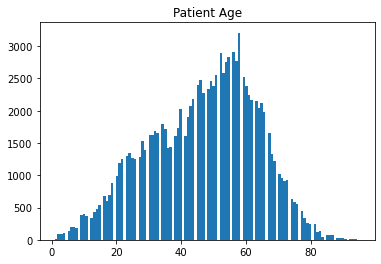

In [11]:
patient_age = all_xray_df[all_xray_df['Patient Age'].between(0, 120)]['Patient Age']
plt.hist(patient_age, bins = 120)
plt.title('Patient Age')

***
**NOTE**

There is nothing strange in the distribution, most of these studies are more common in adults, hence we have more data in the range between 30 to 70.

***

Text(0.5, 1.0, 'View Positions')

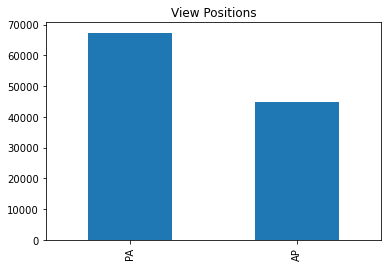

In [12]:
all_xray_df['View Position'].value_counts().plot(kind = 'bar')
plt.title('View Positions')

In [13]:
pa_percentage = len(all_xray_df[all_xray_df['View Position'] == 'PA']) / len(all_xray_df)
ap_percentage = len(all_xray_df[all_xray_df['View Position'] == 'AP']) / len(all_xray_df)
print(pa_percentage, ap_percentage)

0.6003389225829469 0.39966107741705315


***
**NOTE**

There is an imbalance between images taken from PA and AP.
Let's look at the gender distribution.

***

Text(0.5, 1.0, 'Gender')

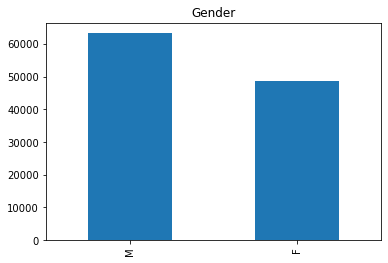

In [14]:
all_xray_df['Patient Gender'].value_counts().plot(kind = 'bar')
plt.title('Gender')

***
**NOTE**

There is a light imbalance. 
Let's look at the combination distribution taking into account the gender and View Position.

***

In [18]:
test = all_xray_df.copy()

deltas = [
    ('PA_male', 'PA', 'M'),
    ('PA_female', 'PA', 'F'),
    
    ('AP_male', 'AP', 'M'),
    ('AP_female', 'AP', 'F')
]

for delta in deltas:
    column, view_position, gender = delta
    test[column] = test.apply(lambda row: 1 if row['View Position'] == view_position and row['Patient Gender'] == gender else 0, axis = 1)

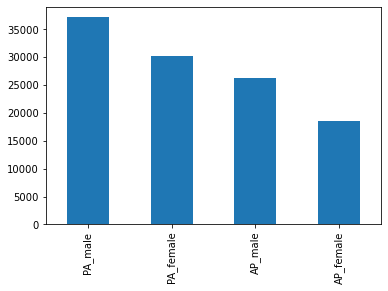

In [19]:
labels = [x[0] for x in deltas]
test[labels].sum().plot(kind='bar')

***
**NOTE**

According to [Physiopedia](https://bit.ly/2WOiMhR) the gold standard for X-Ray is PA (Posterior Anterior, the X-Ray is taken from the back of the patient). We expect to have more PA images for both male and female patients as it is the most common X-Ray.

***

### Let's also look at the distribution for Pneumonia and Age

In [105]:
test = all_xray_df.copy()

deltas = [
    ('Pneumonia_male', 'M'),
    ('Pneumonia_female', 'F'),
]

for delta in deltas:
    column, gender = delta
    test[column] = test.apply(lambda row: 1 if row['Pneumonia'] == 1 and row['Patient Gender'] == gender else 0, axis = 1)

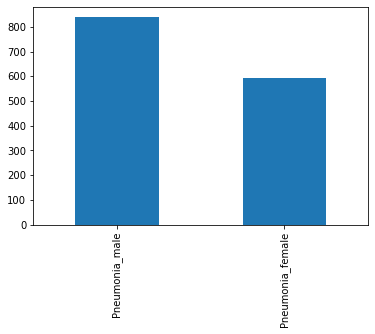

In [106]:
labels = [x[0] for x in deltas]
test[labels].sum().plot(kind='bar')

In [115]:
pneumonia_male_count = test['Pneumonia_male'].sum()
pneumonia_female_count = test['Pneumonia_female'].sum()

total_pneumonia = test['Pneumonia'].sum()

print("Pneumonia male findings: {}".format(pneumonia_male_count / total_pneumonia))
print('Pneumonia female findings: {}'.format(pneumonia_female_count / total_pneumonia))

Pneumonia male findings: 0.5856044723969253
Pneumonia female findings: 0.4143955276030748


***
**NOTE**

There are about 20% most findings of Pneumonia in males than females in this dataset.

***

## Let's now look to the finding labels.

[Text(0, 0.5, 'Number of Images with Label')]

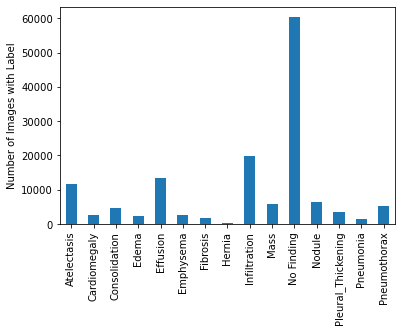

In [20]:
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

### Percentage of findings

In [21]:
(all_xray_df[all_labels].sum()/len(all_xray_df)).sort_values(ascending=False)

No Finding            0.538361
Infiltration          0.177435
Effusion              0.118775
Atelectasis           0.103095
Nodule                0.056466
Mass                  0.051570
Pneumothorax          0.047289
Consolidation         0.041625
Pleural_Thickening    0.030191
Cardiomegaly          0.024759
Emphysema             0.022440
Edema                 0.020540
Fibrosis              0.015037
Pneumonia             0.012763
Hernia                0.002025
dtype: float64

***
**NOTE**

Pneumonia is highly imbalanced, being only ~1.3% of the total set, having `No Finding` as the highest occurrence with a 53.8%. It appears that Infiltration, Effusion and Atelectasis are the top 3 most common findings in this dataset.

***

# Distribution of other diseases that are comorbid with pneumonia

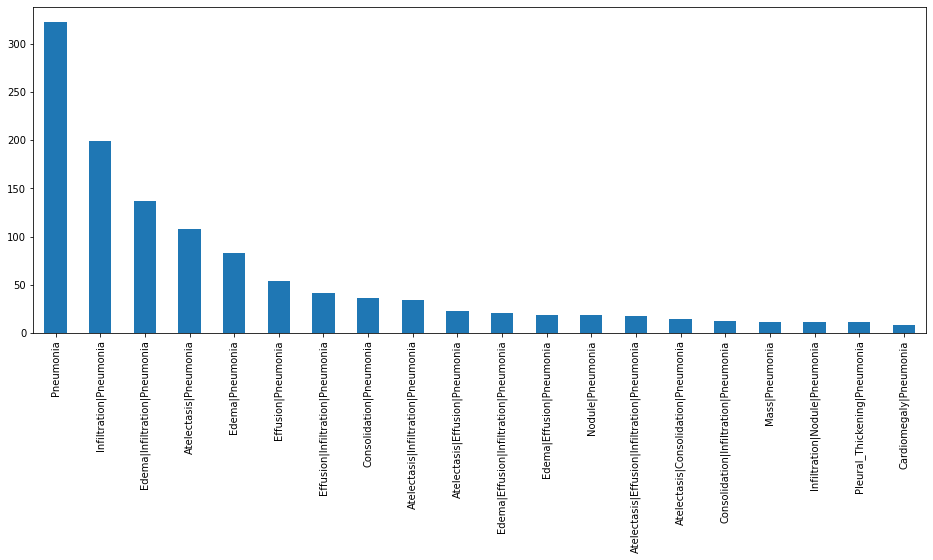

In [120]:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia == 1]['Finding Labels'].value_counts()[0:20].plot(kind = 'bar')

**NOTE**

From the above graph, we can see Pneumonia occurrs mostly on its own most of the time, comorbid with Infiltration, Edema, Atelectasis and Effusion. Let's look to their distribution.

***

### Let's see the distributions of the top 4 most common findings alongside Pneumonia

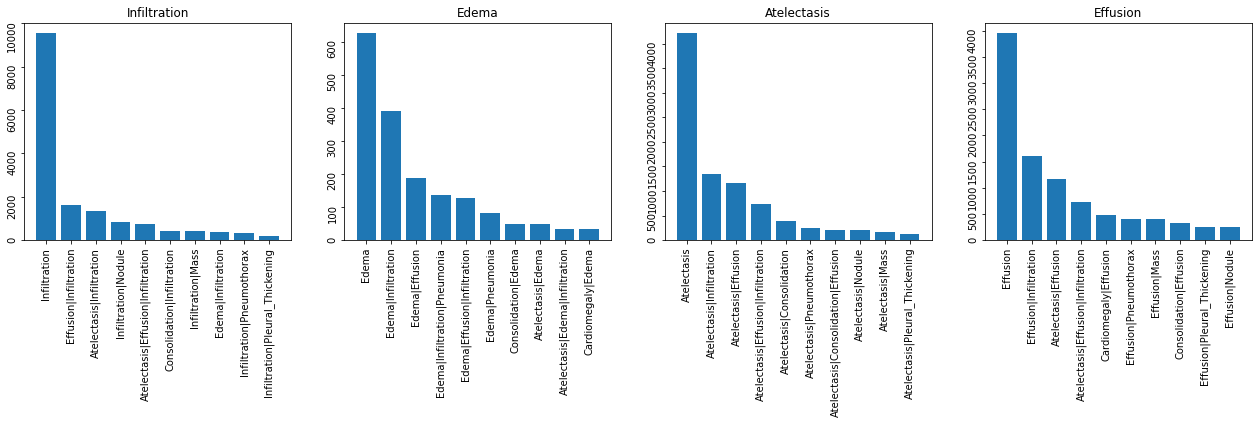

In [142]:
labels = ['Infiltration', 'Edema', 'Atelectasis', 'Effusion']

fig, m_axs = plt.subplots(1, 4, figsize = (22, 4))
for label, c_ax in zip(labels, m_axs.flatten()):
    data = all_xray_df[all_xray_df[label] == 1]['Finding Labels'].value_counts()[0:10]
    c_ax.bar(data.index, data)
    
    c_ax.tick_params(labelrotation=90)
    c_ax.set_title(label)

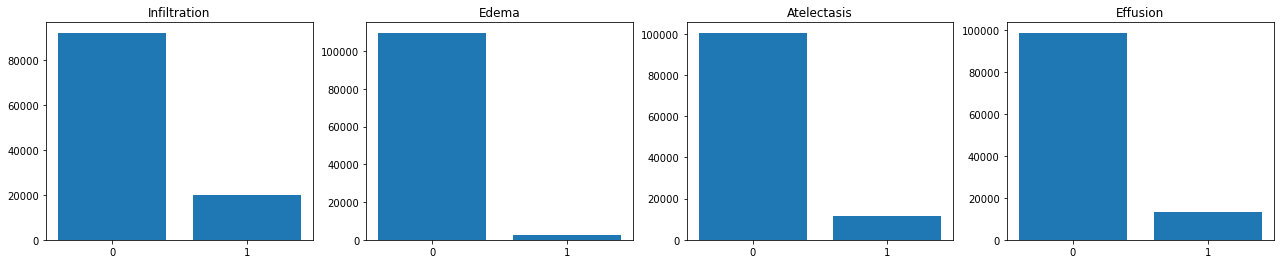

In [192]:
labels = ['Infiltration', 'Edema', 'Atelectasis', 'Effusion']

fig, m_axs = plt.subplots(1, 4, figsize = (22, 4))
for label, c_ax in zip(labels, m_axs.flatten()):
    data = all_xray_df[label].value_counts()
    c_ax.bar(data.index, data)
    c_ax.set_xticks([0,1])
    c_ax.set_title(label)

***
**NOTE**

As expected, the classes Infiltration, Edema, Atelectasis and Effusion are highly imbalanced. Let's look at the ages distribution of patients with Pneumonia, Infiltration, and Effusion (ignoring Edema as it barely occurs).

***

### Lastly, let's look at the distribution of Pneumonia and the combination of Pneumonia comorbid with other findings

0.22501747030048916
0.7749825296995109


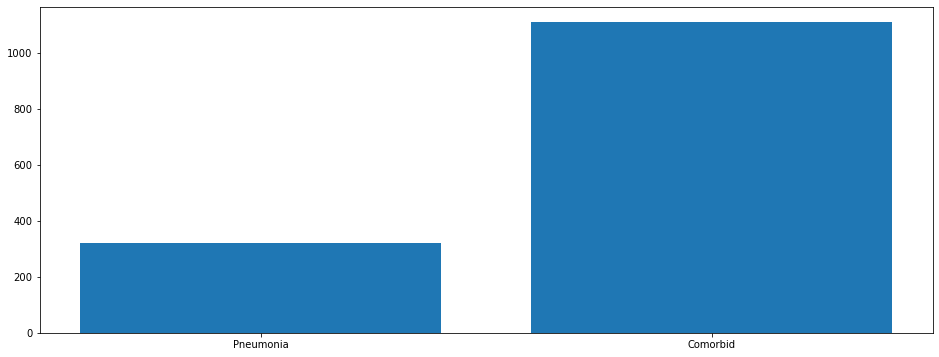

In [217]:
plt.figure(figsize=(16,6))
findings = all_xray_df[all_xray_df.Pneumonia == 1]['Finding Labels'].value_counts()
total = sum(findings.values[1:])
findings.drop(findings.index[1:], inplace = True)
findings['Comorbid'] = total
plt.bar(findings.index, findings)

print(findings.values[0] / sum(findings.values))
print(findings.values[1] / sum(findings.values))

***
**NOTE**

In the above distribution we can observe, there are 3 times more data comorbid with Pneumonia than Pneumonia happening alone.

***

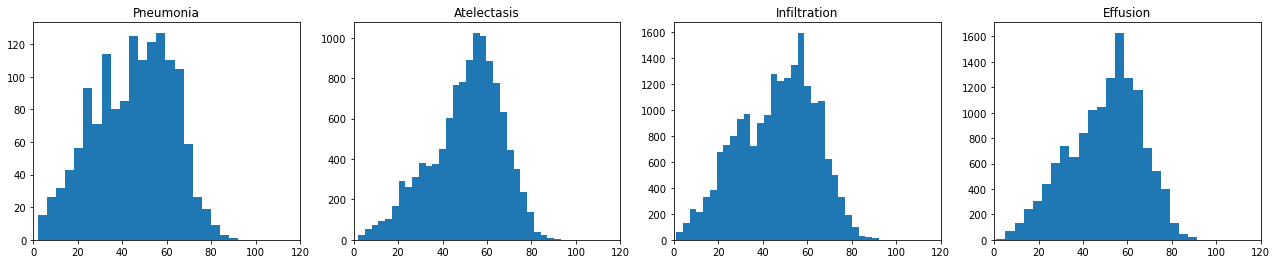

In [23]:
labels = [('Pneumonia', 100), ('Atelectasis', 50), ('Infiltration', 50), ('Effusion', 100)]

fig, m_axs = plt.subplots(1, 4, figsize = (22, 4))
for label_data, c_ax in zip(labels, m_axs.flatten()):
    label, bins = label_data
    data = all_xray_df[all_xray_df[label] == 1]['Patient Age']
    c_ax.hist(data, bins = bins)
    c_ax.set_xlim(0,120)
    c_ax.set_title(label)

***
**NOTE**

The distributions age look pretty similar between them, if we have a closer look to Infiltration and Effussion we can even notice how similar are the total amount of patients.

***

# Number of disease per patient

In [29]:
filtered = all_xray_df[all_xray_df['Finding Labels'] != 'No Finding']

unique_ids = filtered['Patient ID'].unique()

count = []
for identifier in unique_ids:
    df = filtered[filtered["Patient ID"] == identifier]['Finding Labels']
    unique_labels = np.unique(list(chain(*df.map(lambda x: x.split('|')).tolist())))
    unique_labels = [x for x in unique_labels if len(x) > 0]
    count.append((identifier, unique_labels))

In [30]:
new_count = sorted(count, key = lambda c: len(c[1]), reverse = True)
for d in new_count[:5]:
    print(str(d[0]) + ' - ' + str(len(d[1])))
    print('\t' + ','.join(d[1]))
    print()

12021 - 13
	Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax

14022 - 13
	Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax

16778 - 13
	Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax

26451 - 13
	Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax

1836 - 12
	Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Fibrosis,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax



***
**NOTE**

We can see there are some patients with many findings, this could potentially make our model unstable as the CNN will also learn non pneumonia features.

***

# Let's look at if and how age and gender relate to Pneumonia

In [35]:
pneumonia_sizes = all_xray_df['Pneumonia'].values
pneumonia_inds = np.where(~np.isnan(pneumonia_sizes))
ages = all_xray_df.iloc[pneumonia_inds]['Patient Age']
pneumonia_sizes = pneumonia_sizes[pneumonia_inds]
scipy.stats.pearsonr(pneumonia_sizes, ages)

(-0.013329295550928684, 8.067938685451712e-06)

***
**NOTE**

The Pearson's coerrelation coefficient of -0.01, tells us that `age` and `Pneumonia` are not correlated, at least on this dataset.

***

In [106]:
m_mean = np.mean(all_xray_df[all_xray_df['Patient Gender']== 'M']['Pneumonia'])
f_mean = np.mean(all_xray_df[all_xray_df['Patient Gender']== 'F']['Pneumonia'])
print(m_mean, f_mean)

0.01323018629617935 0.012156621566215662


In [105]:
ap_mean = np.mean(all_xray_df[all_xray_df['View Position']== 'AP']['Pneumonia'])
pa_mean = np.mean(all_xray_df[all_xray_df['View Position']== 'PA']['Pneumonia'])
print(ap_mean, pa_mean)

0.01787547422450346 0.009359679096716684


Even though there are less images from AP, it gives us a higher mean compared to PA

### Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

In [38]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')

all_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

for label in all_labels:
    sample_df[label] = sample_df['Finding Labels'].map(lambda finding: 1 if label in finding else 0)
    
sample_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,...,1,0,0,1,0,0,0,1,0,1
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,...,1,0,0,0,0,0,0,0,0,0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,...,0,0,0,0,0,1,0,0,0,0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,0,0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0


In [39]:
sample_df_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(sample_df_paths), ', Total Headers', sample_df.shape[0])
sample_df['path'] = sample_df['Image Index'].map(sample_df_paths.get)

Scans found: 112120 , Total Headers 5606


In [40]:
sample_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,...,0,0,1,0,0,0,1,0,1,/data/images_001/images/00000013_005.png
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,/data/images_001/images/00000013_026.png
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,...,0,0,0,0,1,0,0,0,0,/data/images_001/images/00000017_001.png
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,0,/data/images_001/images/00000030_001.png
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,/data/images_001/images/00000032_001.png


### Let's look to images where pneumonia appears alone

In [53]:
rows = 3
cols = 4
img_paths = sample_df[sample_df['Finding Labels'] == 'Pneumonia']['path'].sample(n=rows * cols).values

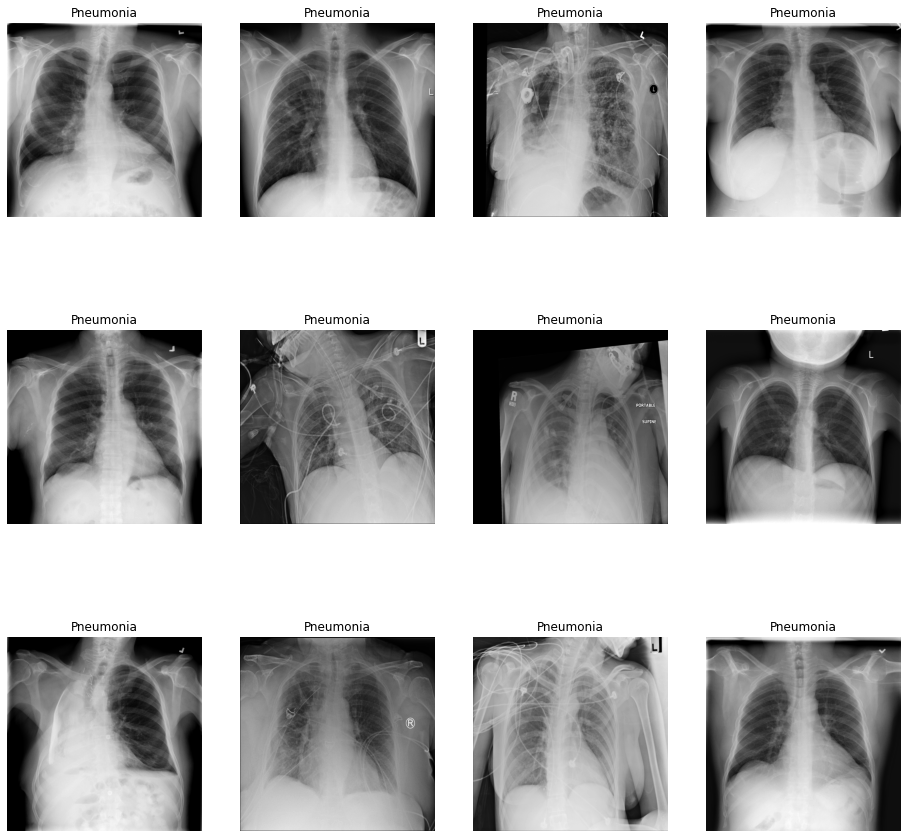

In [59]:
_, axs = plt.subplots(rows,cols, figsize = (16, 16))
axs = axs.flatten()

for img_path, ax in zip(img_paths, axs):
    img = plt.imread(img_path)
    ax.imshow(img,cmap='gray')
    labels = sample_df[sample_df['Image Index'] == img_path.split('/')[-1]]['Finding Labels'].values[0]
    ax.set_title(labels)
    ax.axis('off')

***
**NOTE**

We can appreciate similar patterns in these images.

***

### Let's analyse the intensity of the only Pneumonia images

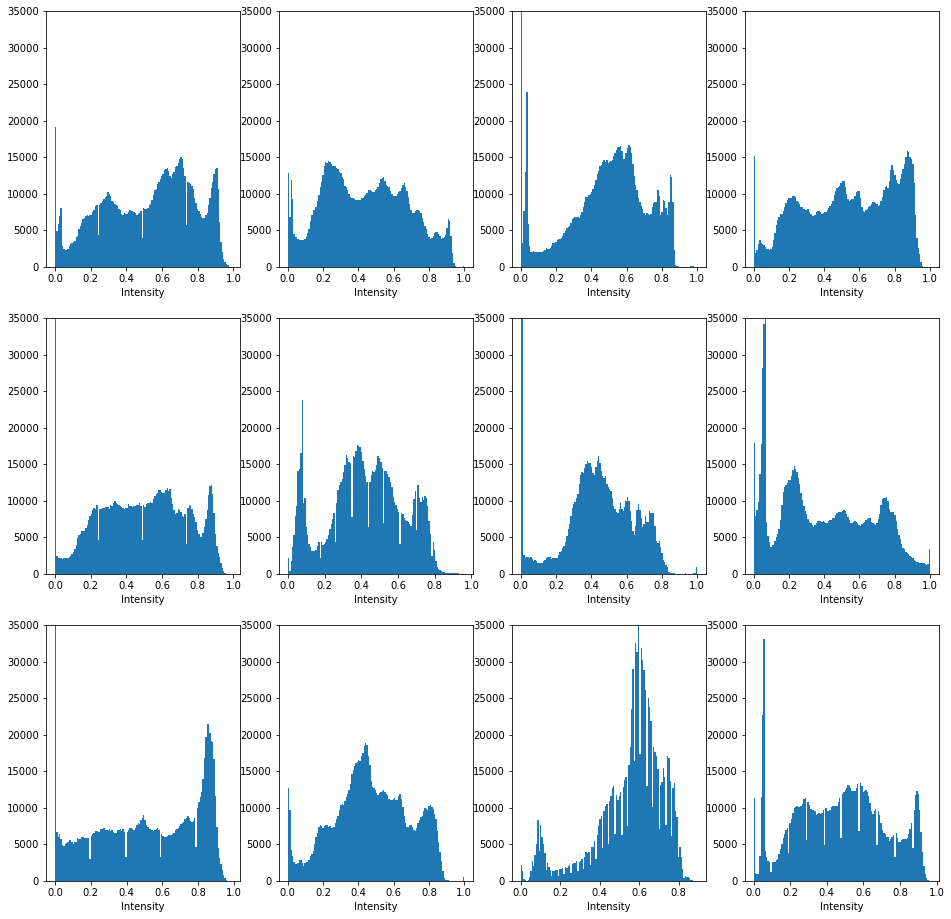

In [66]:
_, axs = plt.subplots(rows,cols, figsize = (16, 16))
axs = axs.flatten()

for img_path, ax in zip(img_paths, axs):
    img = plt.imread(img_path)
    ax.hist(img.flatten(), bins = 128)
    ax.set_ylim(0,35000)
    ax.set_xlabel('Intensity')

***
**NOTE**

Intensity values are pretty similar, ranging from 0.2 to 0.8

***

### Now, let's look to images where pneumonia appears alongside other findings


In [67]:
rows = 4
cols = 4
img_paths = sample_df[sample_df['Pneumonia'] == 1]['path'].sample(n=rows * cols).values

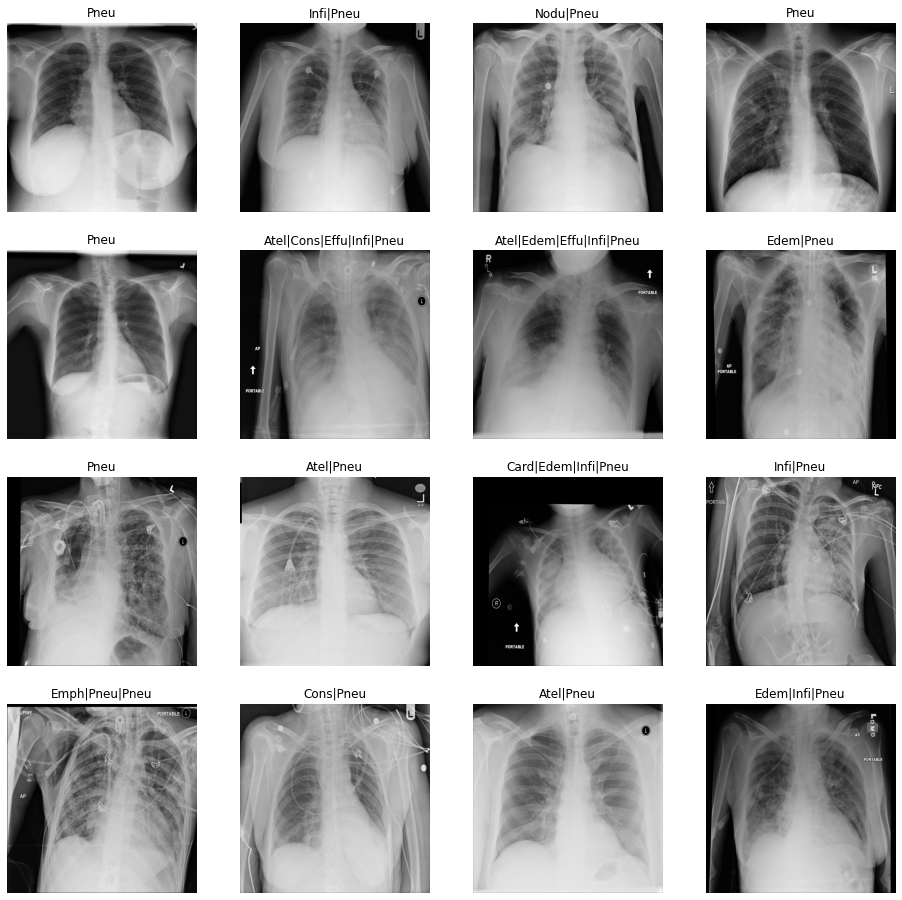

In [86]:
_, axs = plt.subplots(rows,cols, figsize = (16, 16))
axs = axs.flatten()

for img_path, ax in zip(img_paths, axs):
    img = plt.imread(img_path)
    ax.imshow(img,cmap='gray')
    labels = sample_df[sample_df['Image Index'] == img_path.split('/')[-1]]['Finding Labels'].values[0]
    labels = [l[:4] for l in labels.split('|')]
    labels = '|'.join(labels)
    ax.set_title(labels)
    ax.axis('off')

# Draw some histograms with No Finding

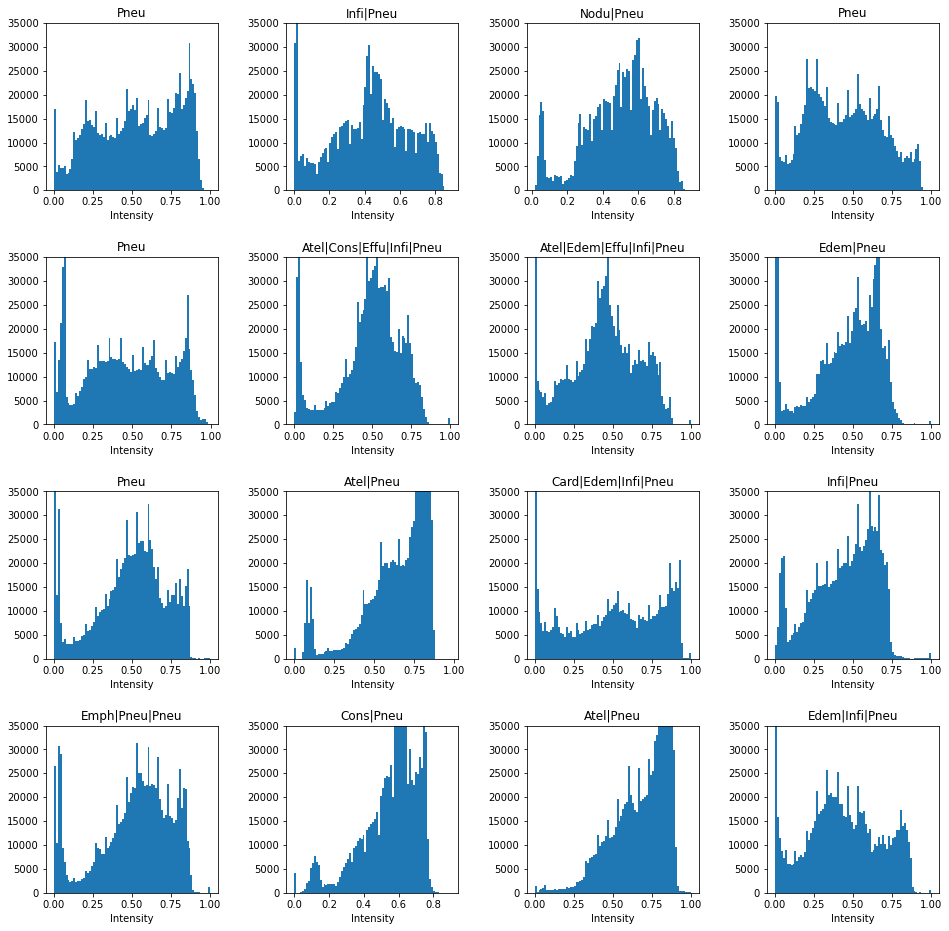

In [96]:
_, axs = plt.subplots(rows,cols, figsize = (16, 16))
plt.subplots_adjust(wspace = 0.4, hspace = 0.4)
axs = axs.flatten()

for img_path, ax in zip(img_paths, axs):
    img = plt.imread(img_path)
    ax.hist(img.flatten(), bins = 80)
    
    labels = sample_df[sample_df['Image Index'] == img_path.split('/')[-1]]['Finding Labels'].values[0]
    labels = [l[:4] for l in labels.split('|')]
    labels = '|'.join(labels)
    
    ax.set_title(labels)
    ax.set_ylim(0,35000)
    ax.set_xlabel('Intensity')

# Conclusions

- The Pneumonia class is highly imbalanced, we well need to fix this before training by creating a 50% of Pneumonia classes and 50% of no pneumonia.
- There are 3 times more data comorbid with Pneumonia than Pneumonia happening alone, this will be a challenge when training our model as it will also learn no Pneumonia features.
- The classes PA and AP are slightly imbalanced.
- The Pearson's coerrelation coefficient of -0.01, tells us that `age` and `Pneumonia` are not correlated.
- There are about 20% most findings of Pneumonia in males than females in this dataset.